In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA

import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
telecom = pd.read_csv('telecom_churn_data.csv')

In [3]:
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [5]:
print(telecom['total_rech_amt_6'].isnull().sum(),telecom['total_rech_amt_7'].isnull().sum(), telecom['total_rech_data_6'].isnull().sum(), telecom['total_rech_data_7'].isnull().sum())

(0, 0, 74846, 74428)


In [6]:
#### Imputing missing values

telecom['total_rech_data_6'].fillna(0, inplace=True)
telecom['total_rech_data_7'].fillna(0, inplace=True)
telecom['total_rech_data_8'].fillna(0, inplace=True)
telecom['total_rech_data_9'].fillna(0, inplace=True)
telecom['av_rech_amt_data_6'].fillna(0, inplace=True)
telecom['av_rech_amt_data_7'].fillna(0, inplace=True)
telecom['av_rech_amt_data_8'].fillna(0, inplace=True)
telecom['av_rech_amt_data_9'].fillna(0, inplace=True)
telecom['max_rech_data_6'].fillna(0, inplace=True)
telecom['max_rech_data_7'].fillna(0, inplace=True)
telecom['max_rech_data_8'].fillna(0, inplace=True)
telecom['max_rech_data_9'].fillna(0, inplace=True)


telecom['night_pck_user_6'].fillna(-1, inplace=True)
telecom['night_pck_user_7'].fillna(-1, inplace=True)
telecom['night_pck_user_8'].fillna(-1, inplace=True)
telecom['night_pck_user_9'].fillna(-1, inplace=True)
telecom['fb_user_6'].fillna(-1, inplace=True)
telecom['fb_user_7'].fillna(-1, inplace=True)
telecom['fb_user_8'].fillna(-1, inplace=True)
telecom['fb_user_9'].fillna(-1, inplace=True)

In [7]:
#As per problem statement creating a column of average recharge amount of first two months
telecom['avg_rech_amt'] = ((telecom['total_rech_amt_6'] + telecom['total_rech_data_6']) + (telecom['total_rech_amt_7'] + telecom['total_rech_data_7']))/2

##### As per problem statement creating dataframe which has only customers with average recharge amount more than or equal to 70th percentile of average recharge amount 


In [8]:
Q = telecom.avg_rech_amt.quantile(0.7)

In [9]:
telecom = telecom[telecom.avg_rech_amt >= Q]

In [10]:
telecom.shape

(30019, 227)

In [11]:
telecom['churn'] = np.where(((telecom['total_ic_mou_9']==0) & (telecom['total_og_mou_9']==0)) & ((telecom['vol_2g_mb_9']==0) & (telecom['vol_3g_mb_9']==0)),1,0)

In [12]:
telecom['churn'].shape

(30019,)

In [13]:
telecom.shape

(30019, 228)

In [14]:
#dropping columns with '_9' at the end
new_col = [c for c in telecom.columns if c[-2:] != '_9']
telecom = telecom[new_col]

In [15]:
# # Checking percentage missing values in each columns
# round(100*(telecom.isnull().sum()/len(telecom.index)))
100*(telecom.isnull().sum()/len(telecom.index))

mobile_number            0.000000
circle_id                0.000000
loc_og_t2o_mou           0.379759
std_og_t2o_mou           0.379759
loc_ic_t2o_mou           0.379759
last_date_of_month_6     0.000000
last_date_of_month_7     0.103268
last_date_of_month_8     0.523002
arpu_6                   0.000000
arpu_7                   0.000000
arpu_8                   0.000000
onnet_mou_6              1.052667
onnet_mou_7              1.009361
onnet_mou_8              3.131350
offnet_mou_6             1.052667
offnet_mou_7             1.009361
offnet_mou_8             3.131350
roam_ic_mou_6            1.052667
roam_ic_mou_7            1.009361
roam_ic_mou_8            3.131350
roam_og_mou_6            1.052667
roam_og_mou_7            1.009361
roam_og_mou_8            3.131350
loc_og_t2t_mou_6         1.052667
loc_og_t2t_mou_7         1.009361
loc_og_t2t_mou_8         3.131350
loc_og_t2m_mou_6         1.052667
loc_og_t2m_mou_7         1.009361
loc_og_t2m_mou_8         3.131350
loc_og_t2f_mou

In [16]:
max(100*(telecom.isnull().sum()/len(telecom.index)))

61.87747759752157

In [17]:
#dropping columns which have more than 50% NaN values
for cl in telecom.columns:
    if round(100*(telecom[cl].isnull().sum()/len(telecom[cl].index)), 2) > 50:
        telecom = telecom.drop(cl, axis=1)

In [18]:
telecom= telecom.dropna(axis=0)

In [19]:
telecom.shape

(7572, 174)

In [20]:
# All of the object datatype columns are of dates. We are dropping those here
obj_col =telecom.select_dtypes(include=['object']).columns

In [21]:
obj_col

Index([u'last_date_of_month_6', u'last_date_of_month_7',
       u'last_date_of_month_8', u'date_of_last_rech_6', u'date_of_last_rech_7',
       u'date_of_last_rech_8', u'date_of_last_rech_data_6',
       u'date_of_last_rech_data_7', u'date_of_last_rech_data_8'],
      dtype='object')

In [22]:
telecom = telecom.drop(obj_col,axis=1)

In [23]:
pd.set_option('display.max_rows', 500)
telecom.nunique().sort_values(ascending=True)


std_ic_t2o_mou_6         1
circle_id                1
loc_og_t2o_mou           1
std_og_t2o_mou           1
loc_ic_t2o_mou           1
std_ic_t2o_mou_7         1
std_ic_t2o_mou_8         1
std_og_t2c_mou_6         1
std_og_t2c_mou_7         1
std_og_t2c_mou_8         1
night_pck_user_7         2
night_pck_user_6         2
churn                    2
fb_user_6                2
fb_user_7                2
fb_user_8                2
night_pck_user_8         2
monthly_2g_6             5
monthly_2g_7             6
monthly_2g_8             6
monthly_3g_8            12
monthly_3g_6            12
monthly_3g_7            15
sachet_3g_6             25
count_rech_3g_6         25
sachet_3g_7             26
count_rech_3g_7         27
count_rech_3g_8         29
sachet_3g_8             29
sachet_2g_6             31
count_rech_2g_6         31
count_rech_2g_8         33
sachet_2g_7             34
count_rech_2g_7         34
sachet_2g_8             34
total_rech_data_6       37
total_rech_data_7       40
m

In [24]:
cat_list= ['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']
telecom_categorical= telecom[cat_list]
le = preprocessing.LabelEncoder()
telecom_categorical = telecom_categorical.apply(le.fit_transform)
telecom_categorical.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8
33,1,1,0,1,1,1
53,0,0,0,1,0,0
56,0,0,0,1,1,1
57,0,0,0,1,1,1
61,0,0,0,1,1,1


In [25]:
telecom_numerical = telecom.drop(cat_list, axis=1)

In [26]:
telecom_numerical = telecom_numerical.drop('churn', axis= 1)

In [27]:
telecom_numerical.nunique().sort_values(ascending=True)


std_ic_t2o_mou_6         1
std_ic_t2o_mou_7         1
std_ic_t2o_mou_8         1
std_og_t2c_mou_6         1
std_og_t2c_mou_7         1
std_og_t2c_mou_8         1
circle_id                1
loc_og_t2o_mou           1
std_og_t2o_mou           1
loc_ic_t2o_mou           1
monthly_2g_6             5
monthly_2g_7             6
monthly_2g_8             6
monthly_3g_8            12
monthly_3g_6            12
monthly_3g_7            15
count_rech_3g_6         25
sachet_3g_6             25
sachet_3g_7             26
count_rech_3g_7         27
count_rech_3g_8         29
sachet_3g_8             29
sachet_2g_6             31
count_rech_2g_6         31
count_rech_2g_8         33
count_rech_2g_7         34
sachet_2g_7             34
sachet_2g_8             34
total_rech_data_6       37
total_rech_data_7       40
max_rech_data_6         41
max_rech_data_8         42
max_rech_data_7         44
total_rech_data_8       45
og_others_7             46
og_others_8             49
spl_ic_mou_8            62
s

In [28]:
#To capture maximum variance let's drop the columns which have less than or equal to 6 unique values
telecom_numerical = telecom_numerical.loc[:,telecom.apply(pd.Series.nunique) >6]

In [29]:
telecom_numerical.shape

(7572, 145)

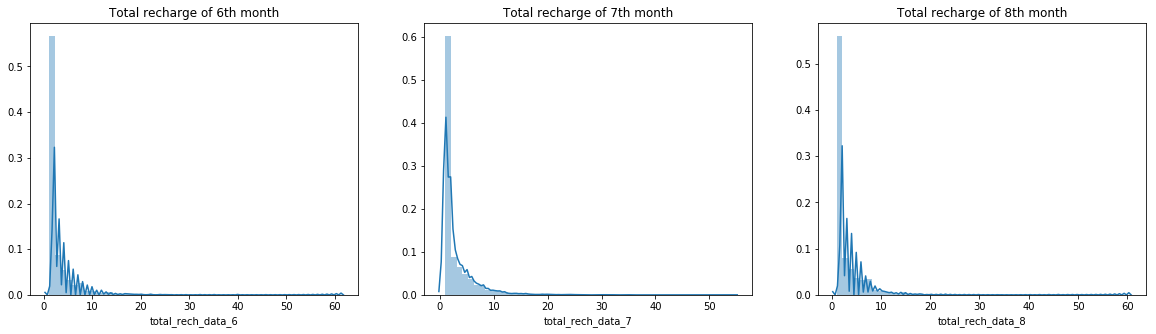

In [30]:
plt.figure(figsize=(20, 5))

# subplot 1
plt.subplot(131)
plt.title('Total recharge of 6th month')
sns.distplot(telecom_numerical['total_rech_data_6'])
# subplot 2 
plt.subplot(132)
plt.title('Total recharge of 7th month')
sns.distplot(telecom_numerical['total_rech_data_7'])


# subplot 3
plt.subplot(133)
plt.title('Total recharge of 8th month')
sns.distplot(telecom_numerical['total_rech_data_8'])


plt.show()

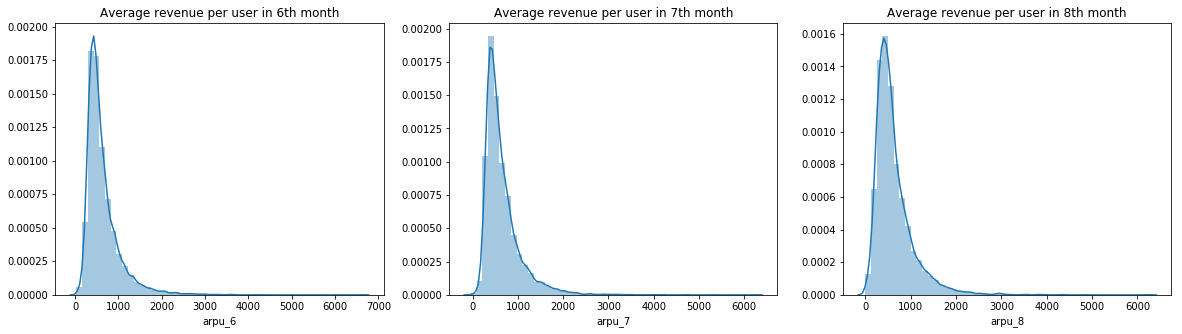

In [31]:
plt.figure(figsize=(20, 5))

# subplot 1
plt.subplot(131)
plt.title('Average revenue per user in 6th month')
sns.distplot(telecom_numerical['arpu_6'])
# subplot 2 
plt.subplot(132)
plt.title('Average revenue per user in 7th month')
sns.distplot(telecom_numerical['arpu_7'])


# subplot 3
plt.subplot(133)
plt.title('Average revenue per user in 8th month')
sns.distplot(telecom_numerical['arpu_8'])


plt.show()

#### Trying to create derived variables like the one we created at the very beginning: average of two months particular attribute
First I tried to run the code without this part, ant then I got the results that to cover 95% variation I will need 65 components.
And same result after this

In [32]:
# new_col_6 = [c for c in telecom.columns if c[-2:] == '_6']
# new_col_7 = [c for c in telecom.columns if c[-2:] == '_7']
# new_col_8 = [c for c in telecom.columns if c[-2:] == '_8']

In [33]:
# print(len(new_col_6),len(new_col_7), len(new_col_8))

In [34]:
# dummy_col = [x[:-2] for x in new_col_6]

In [35]:
# dummy_col

In [36]:
# for val in dummy_col:
#     telecom[val+'_avg'] = (telecom[val+'_6'] + telecom[val+'_7'] + telecom[val+'_8'])/3


In [37]:
# telecom = telecom.drop(new_col_6,axis=1)

In [38]:
# telecom = telecom.drop(new_col_7,axis=1)

In [39]:
main_frame = pd.concat([telecom_numerical,telecom_categorical, telecom['churn']], axis=1)

In [40]:
main_frame.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,jun_vbc_3g,sep_vbc_3g,avg_rech_amt,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,churn
33,7000149764,977.020,2362.833,409.230,0.00,0.00,0.00,0.00,0.00,0.00,...,1714.67,0.0,1938.5,1,1,0,1,1,1,0
53,7002188521,978.077,1141.296,706.020,135.14,119.59,102.69,479.31,543.18,261.34,...,0.00,0.0,1270.0,0,0,0,1,0,0,0
56,7002180748,452.624,320.548,368.807,34.46,43.11,50.61,131.59,90.61,84.31,...,1459.45,0.0,461.0,0,0,0,1,1,1,0
57,7001682585,1201.298,687.704,602.052,61.23,7.39,62.89,165.41,211.31,168.01,...,1892.32,0.0,1149.5,0,0,0,1,1,1,0
61,7000152517,565.516,390.307,430.911,178.41,226.81,170.11,186.68,45.08,145.08,...,0.00,0.0,574.5,0,0,0,1,1,1,0


### Above dummy variables section has to be changed

In [41]:
X = main_frame.drop(['mobile_number','churn'], axis=1)
y = main_frame[['churn']]

In [42]:
# Normalising data
X = (X-X.mean())/X.std()


In [43]:
print(X.shape)
print(y.shape)

(7572, 150)
(7572, 1)


## Model Building
Let's start by splitting our data into a training set and a test set.

### Splitting Data into Training and Test Sets

In [44]:
X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.7,test_size=0.3,random_state=100)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5300, 150)
(2272, 150)
(5300, 1)
(2272, 1)


In [46]:
# Percentage of churned customers(instances) in traing dataset
y_train[y_train['churn']==1].count()/y_train['churn'].count() * 100

churn    2.283019
dtype: float64

In [47]:
y_test[y_test['churn']==1].count()/y_test['churn'].count() * 100

churn    2.244718
dtype: float64

### AdaBoost

In [48]:
# fit model on training data with default hyperparameters
shallow_tree = DecisionTreeClassifier(max_depth=3, random_state=100)

In [49]:
shallow_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [50]:
# test error
y_pred = shallow_tree.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
score

0.9744718309859155

In [51]:
# adaboost with the shallow_tree as base estimator

estimators = list(range(1, 70, 5))

abc_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(
    base_estimator=shallow_tree, 
    n_estimators = n_est)
    
    ABC.fit(X_train, y_train)
    y_pred = ABC.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    abc_scores.append(score)

In [52]:
abc_scores

[0.9744718309859155,
 0.9713908450704225,
 0.9740316901408451,
 0.9740316901408451,
 0.9727112676056338,
 0.9696302816901409,
 0.9700704225352113,
 0.9709507042253521,
 0.9709507042253521,
 0.971830985915493,
 0.9735915492957746,
 0.9735915492957746,
 0.9735915492957746,
 0.9735915492957746]

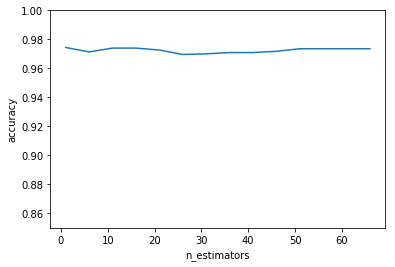

In [53]:
# plot test scores and n_estimators
# plot
plt.plot(estimators, abc_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.85, 1])
plt.show()

### XgBoost

#### Running first model(Default hyperparameters)

In [54]:
# fit model on training data with default hyperparameters
model_21 = XGBClassifier()
model_21.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [55]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred_21 = model_21.predict(X_test)
y_pred_prob = model_21.predict_proba(X_test)

In [56]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred_prob[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 83.61%


In [57]:
#Accuracy score with default parameters in for XgBoost
score21 = metrics.accuracy_score(y_test, y_pred_21)
score21

0.977112676056338

#### Running second model (hyperparameter tuning in XgBoost)

In [58]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=3, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [59]:
# fit the model
model_cv.fit(X_train, y_train)       

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   53.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'subsample': [0.3, 0.6, 0.9], 'learning_rate': [0.2, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [60]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.533587,0.013645,0.974717,0.999528,0.2,0.3,"{u'subsample': 0.3, u'learning_rate': 0.2}",5,0.972851,0.999717,0.974519,0.999434,0.976784,0.999434,0.081284,0.000156,0.001612,0.000133
1,3.403176,0.015204,0.976226,1.000000,0.2,0.6,"{u'subsample': 0.6, u'learning_rate': 0.2}",2,0.976810,1.000000,0.975651,1.000000,0.976217,1.000000,0.146336,0.001515,0.000473,0.000000
2,3.556592,0.015085,0.977170,1.000000,0.2,0.9,"{u'subsample': 0.9, u'learning_rate': 0.2}",1,0.976810,1.000000,0.978482,1.000000,0.976217,1.000000,0.115043,0.000911,0.000959,0.000000
3,2.522515,0.013859,0.970377,0.999906,0.6,0.3,"{u'subsample': 0.3, u'learning_rate': 0.6}",6,0.970588,1.000000,0.969422,0.999717,0.971121,1.000000,0.298608,0.001892,0.000709,0.000133
4,2.890294,0.011717,0.975283,1.000000,0.6,0.6,"{u'subsample': 0.6, u'learning_rate': 0.6}",4,0.974548,1.000000,0.976784,1.000000,0.974519,1.000000,0.115050,0.000535,0.001061,0.000000
5,2.677148,0.011671,0.975660,1.000000,0.6,0.9,"{u'subsample': 0.9, u'learning_rate': 0.6}",3,0.975113,1.000000,0.975651,1.000000,0.976217,1.000000,0.117703,0.000268,0.000451,0.000000


In [61]:
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')


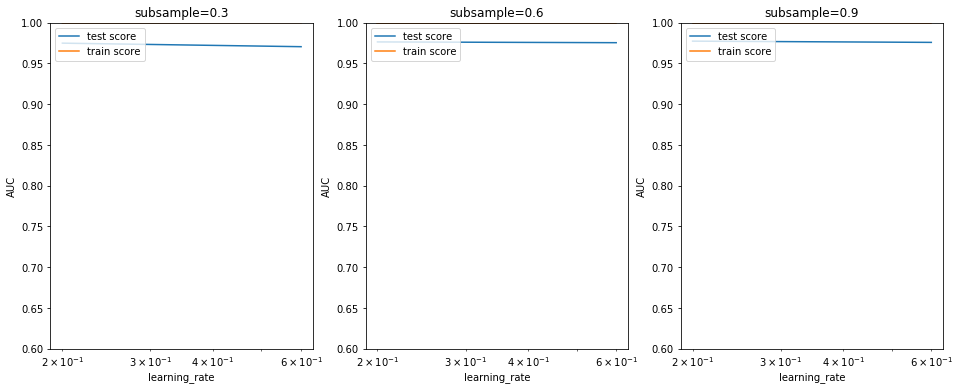

In [62]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

#### Selecting hyperparameters from above plots as: learning_rate=0.2, subsample=0.6

In [63]:
params = {'learning_rate': 0.2,
          'max_depth': 3, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model22 = XGBClassifier(params = params)
model22.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'n_estimators': 200, 'subsample': 0.6, 'learning_rate': 0.2, 'objective': 'binary:logistic', 'max_depth': 3},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [64]:
#AUC score
# predict
y_pred22_prob = model22.predict_proba(X_test)
y_pred22_prob[:10]

array([[0.974842  , 0.025158  ],
       [0.9881389 , 0.01186111],
       [0.9703849 , 0.02961509],
       [0.9871499 , 0.01285011],
       [0.9847389 , 0.01526112],
       [0.9899074 , 0.01009262],
       [0.99165004, 0.00834995],
       [0.9980437 , 0.0019563 ],
       [0.9862018 , 0.01379817],
       [0.9897347 , 0.0102653 ]], dtype=float32)

In [65]:
auc = metrics.roc_auc_score(y_test, y_pred22_prob[:, 1])
auc

0.8360922036531857

In [66]:
y_pred22_acc = model22.predict(X_test)

In [67]:
#Accuracy score with default parameters in for XgBoost
score2 = metrics.accuracy_score(y_test, y_pred22_acc)
score2

0.977112676056338

In [68]:
importance = dict(zip(X_train.columns, model22.feature_importances_))
importance

{'aon': 0.030546624,
 'arpu_2g_6': 0.017684888,
 'arpu_2g_7': 0.003215434,
 'arpu_2g_8': 0.0,
 'arpu_3g_6': 0.006430868,
 'arpu_3g_7': 0.001607717,
 'arpu_3g_8': 0.0,
 'arpu_6': 0.006430868,
 'arpu_7': 0.006430868,
 'arpu_8': 0.03215434,
 'aug_vbc_3g': 0.0,
 'av_rech_amt_data_6': 0.003215434,
 'av_rech_amt_data_7': 0.003215434,
 'av_rech_amt_data_8': 0.059485532,
 'avg_rech_amt': 0.006430868,
 'count_rech_2g_6': 0.0,
 'count_rech_2g_7': 0.0,
 'count_rech_2g_8': 0.003215434,
 'count_rech_3g_6': 0.003215434,
 'count_rech_3g_7': 0.004823151,
 'count_rech_3g_8': 0.004823151,
 'fb_user_6': 0.0,
 'fb_user_7': 0.0,
 'fb_user_8': 0.0,
 'ic_others_6': 0.001607717,
 'ic_others_7': 0.001607717,
 'ic_others_8': 0.001607717,
 'isd_ic_mou_6': 0.001607717,
 'isd_ic_mou_7': 0.003215434,
 'isd_ic_mou_8': 0.001607717,
 'isd_og_mou_6': 0.003215434,
 'isd_og_mou_7': 0.036977492,
 'isd_og_mou_8': 0.004823151,
 'jul_vbc_3g': 0.0,
 'jun_vbc_3g': 0.008038585,
 'last_day_rch_amt_6': 0.003215434,
 'last_day_rch

In [69]:
print(model22.feature_importances_)

[0.00643087 0.00643087 0.03215434 0.00803859 0.00482315 0.
 0.00321543 0.00160772 0.00482315 0.00160772 0.00643087 0.00482315
 0.         0.00482315 0.04501608 0.00643087 0.00482315 0.00160772
 0.01125402 0.0096463  0.01286174 0.00482315 0.00482315 0.
 0.00160772 0.01125402 0.         0.00160772 0.00160772 0.01607717
 0.00643087 0.01286174 0.00321543 0.         0.00160772 0.
 0.         0.00160772 0.         0.01446945 0.00803859 0.00160772
 0.00321543 0.03697749 0.00482315 0.0096463  0.00482315 0.
 0.00160772 0.         0.         0.00321543 0.01286174 0.
 0.01446945 0.00160772 0.00643087 0.01125402 0.00321543 0.03536978
 0.01286174 0.00643087 0.00160772 0.00482315 0.00482315 0.02250804
 0.00803859 0.01446945 0.00321543 0.01768489 0.00321543 0.00803859
 0.00160772 0.         0.         0.00321543 0.00482315 0.01607717
 0.00482315 0.00803859 0.01768489 0.00482315 0.         0.01768489
 0.00160772 0.00321543 0.00160772 0.00160772 0.00160772 0.00160772
 0.00482315 0.01446945 0.0096463  0

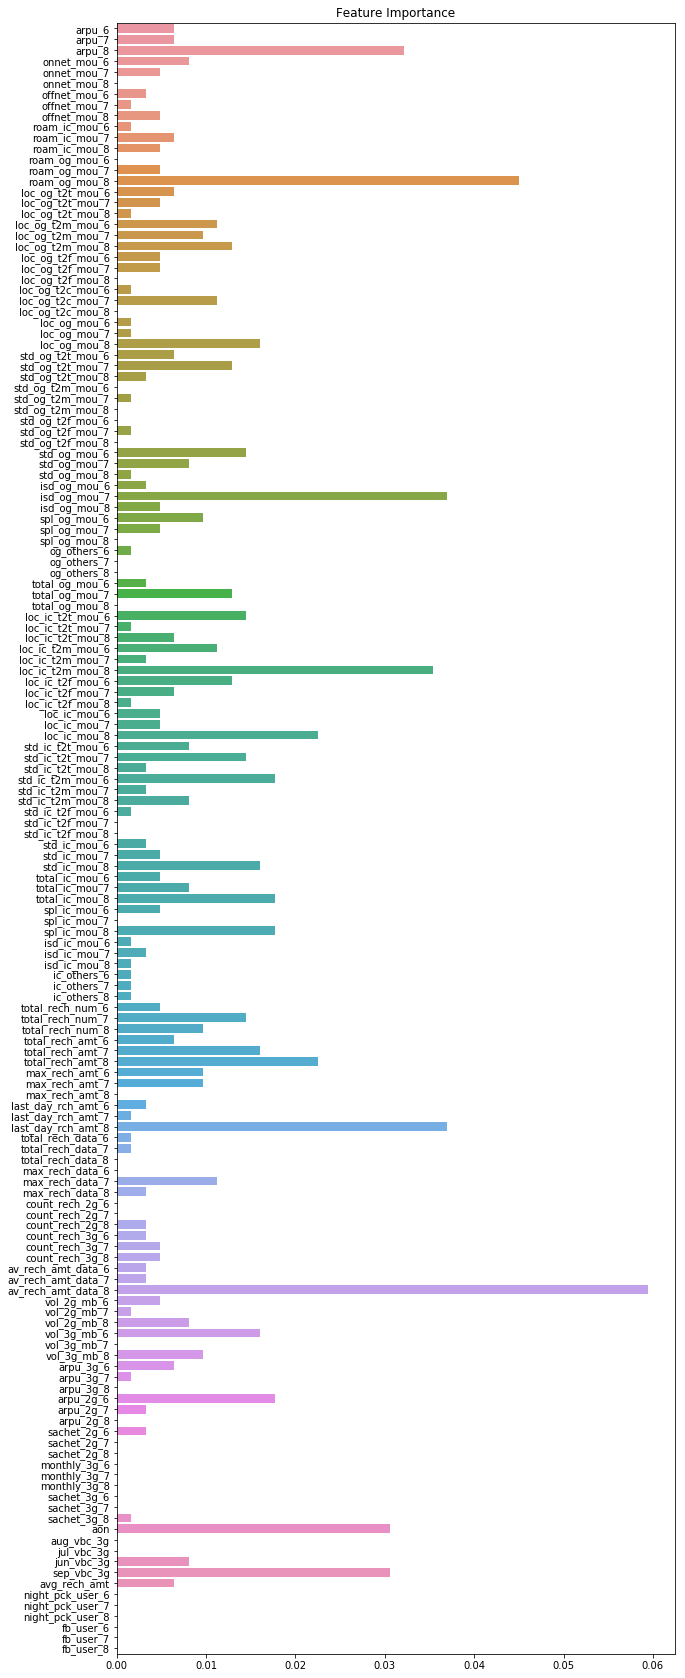

In [70]:
plt.figure(figsize=(10,30))
plt.title('Feature Importance')
sns.barplot(y= X.columns,x=model22.feature_importances_)

In [71]:
importance = dict(zip(X_train.columns, model22.feature_importances_))


imp_gain= model22.get_booster().get_score(importance_type='gain')
gain_val = list(imp_gain.values())


imp_weight= model22.get_booster().get_score(importance_type='weight')
weight_val = list(imp_weight.values())


imp_cover= model22.get_booster().get_score(importance_type='cover')
cover_val = list(imp_cover.values())


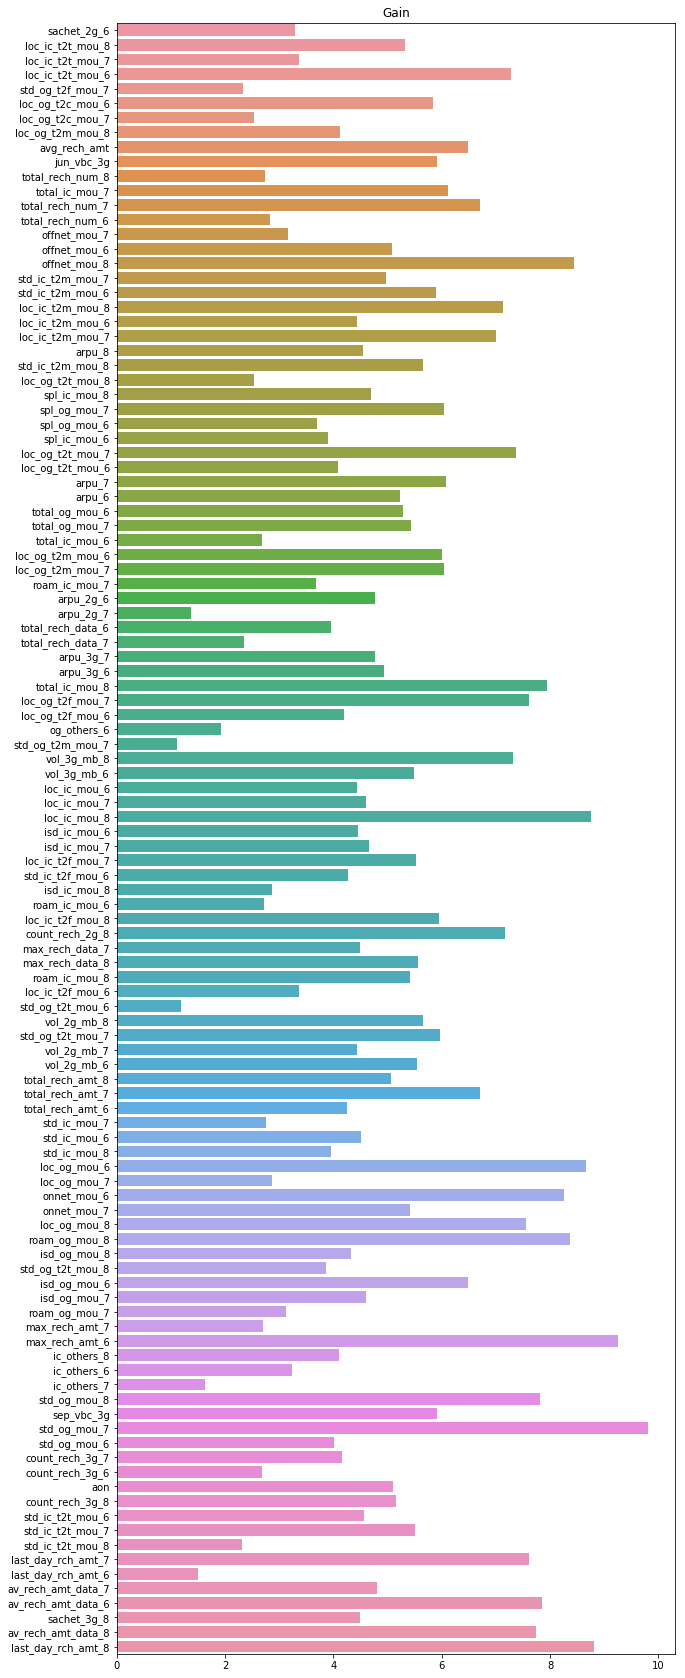

In [72]:
plt.figure(figsize=(10,30))
plt.title('Gain')
sns.barplot(y= list(imp_gain.keys()),x= gain_val)


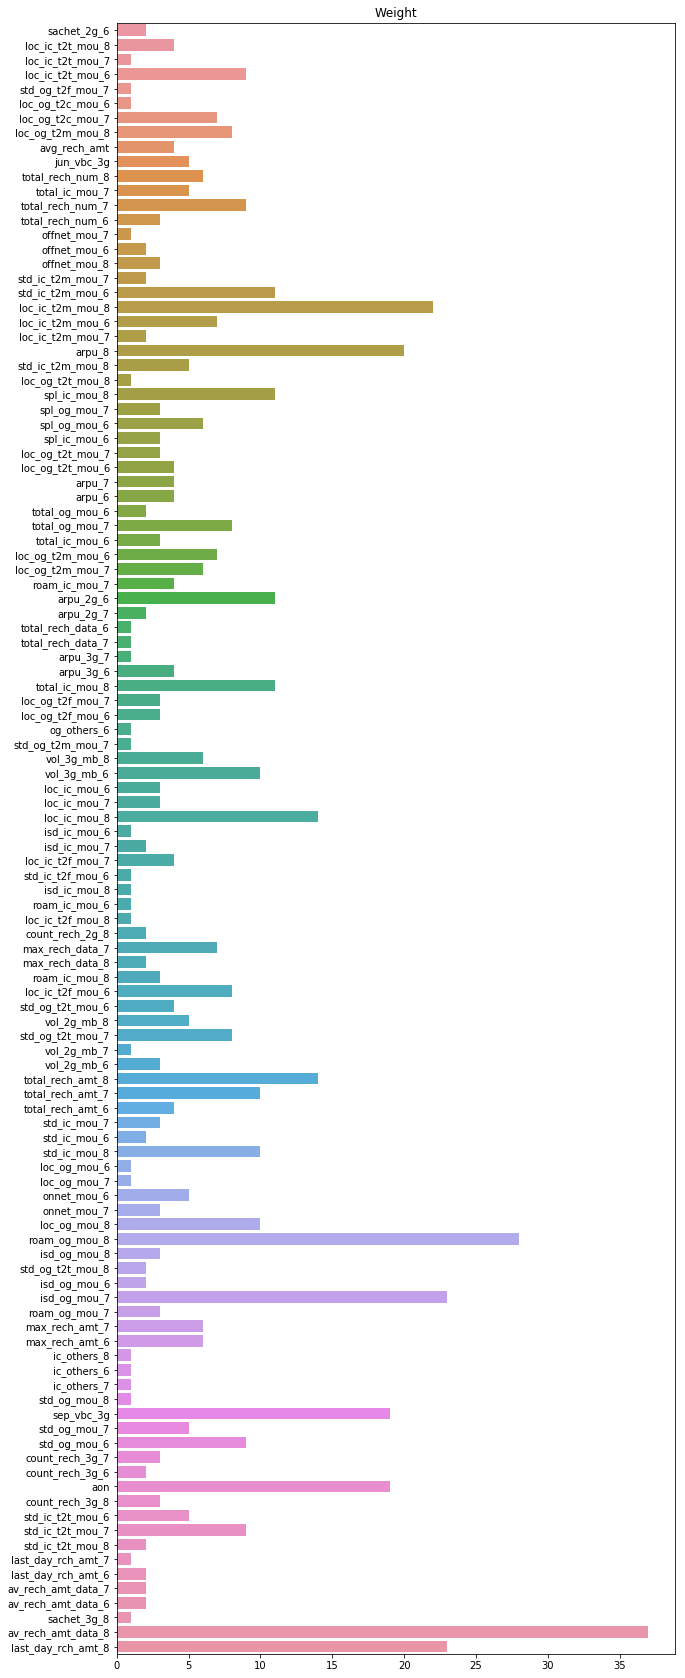

In [73]:
plt.figure(figsize=(10,30))
plt.title('Weight')
sns.barplot(y= list(imp_weight.keys()),x= weight_val)


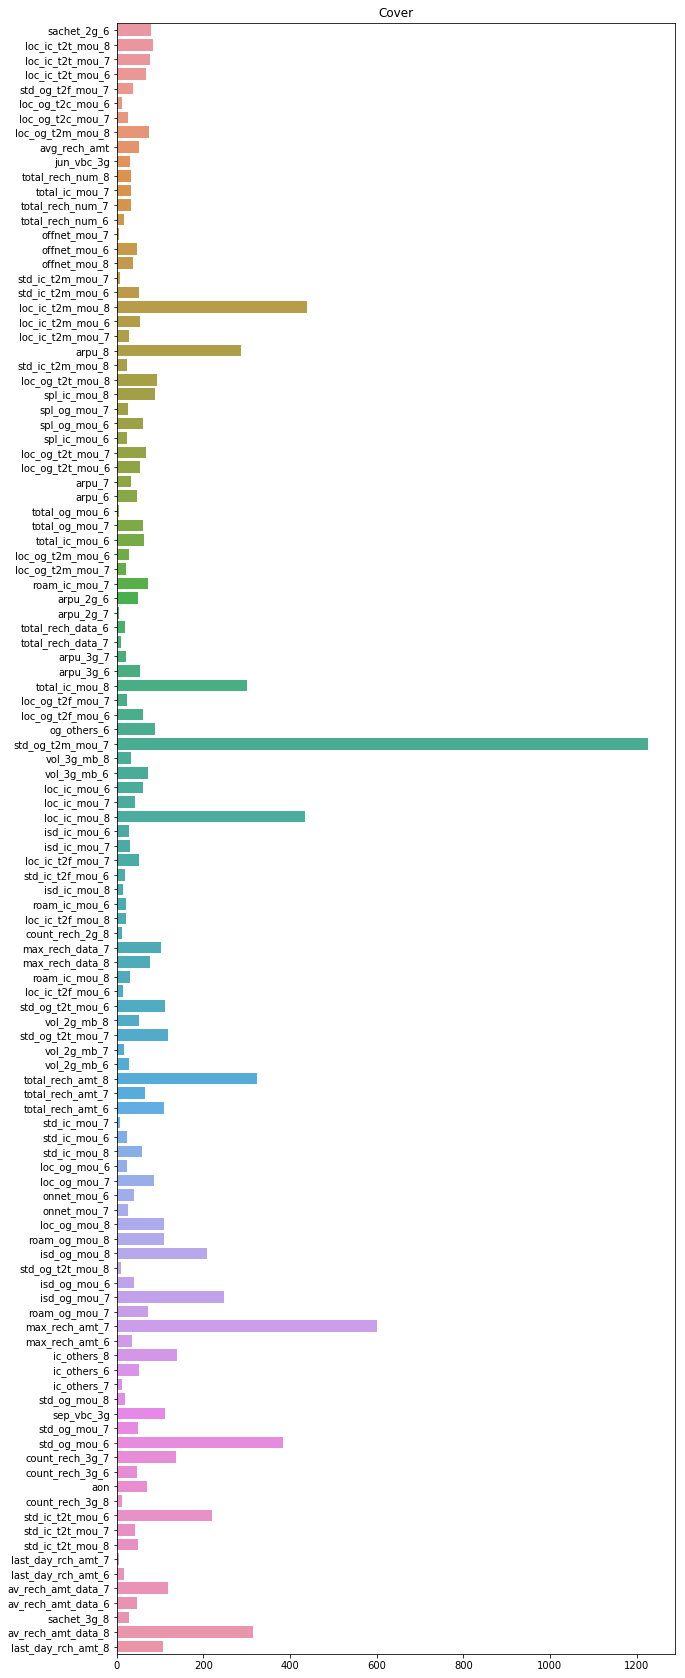

In [74]:
plt.figure(figsize=(10,30))
plt.title('Cover')
sns.barplot(y= list(imp_cover.keys()),x= cover_val)


### PCA on the data

In [75]:
#Creating an instance of PCA
pca1 = PCA(svd_solver='randomized', random_state=100)

In [76]:
#Doing the PCA on the train data
pca1.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
  svd_solver='randomized', tol=0.0, whiten=False)

In [77]:
pca1.components_

array([[ 1.56775384e-01,  1.61540912e-01,  1.56454209e-01, ...,
         4.93153475e-02,  5.05260098e-02,  5.19250675e-02],
       [ 9.87666811e-02,  1.01143939e-01,  1.01498831e-01, ...,
        -6.64177043e-02, -6.88091453e-02, -6.51584772e-02],
       [ 6.28195921e-02,  7.85691059e-02,  6.88930624e-02, ...,
        -1.41758022e-02, -1.28479744e-02, -1.27849235e-02],
       ...,
       [-0.00000000e+00, -5.86648437e-17, -2.39643258e-17, ...,
        -6.85447882e-17,  6.69292589e-17, -5.29439418e-17],
       [ 0.00000000e+00, -2.26777558e-16, -2.47398762e-16, ...,
        -3.21951212e-17, -1.51387115e-16,  2.69967534e-17],
       [-0.00000000e+00,  1.11810108e-16, -5.69810509e-16, ...,
        -1.09067426e-16, -3.33310847e-17, -5.53885543e-17]])

In [78]:
# colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca1.components_[0],'PC2':pca1.components_[1], 'Feature':X_train.columns})
pcs_df.head()

,Feature,PC1,PC2
0,arpu_6,0.156775,0.098767
1,arpu_7,0.161541,0.101144
2,arpu_8,0.156454,0.101499
3,onnet_mou_6,0.022372,0.141262
4,onnet_mou_7,0.020748,0.147364


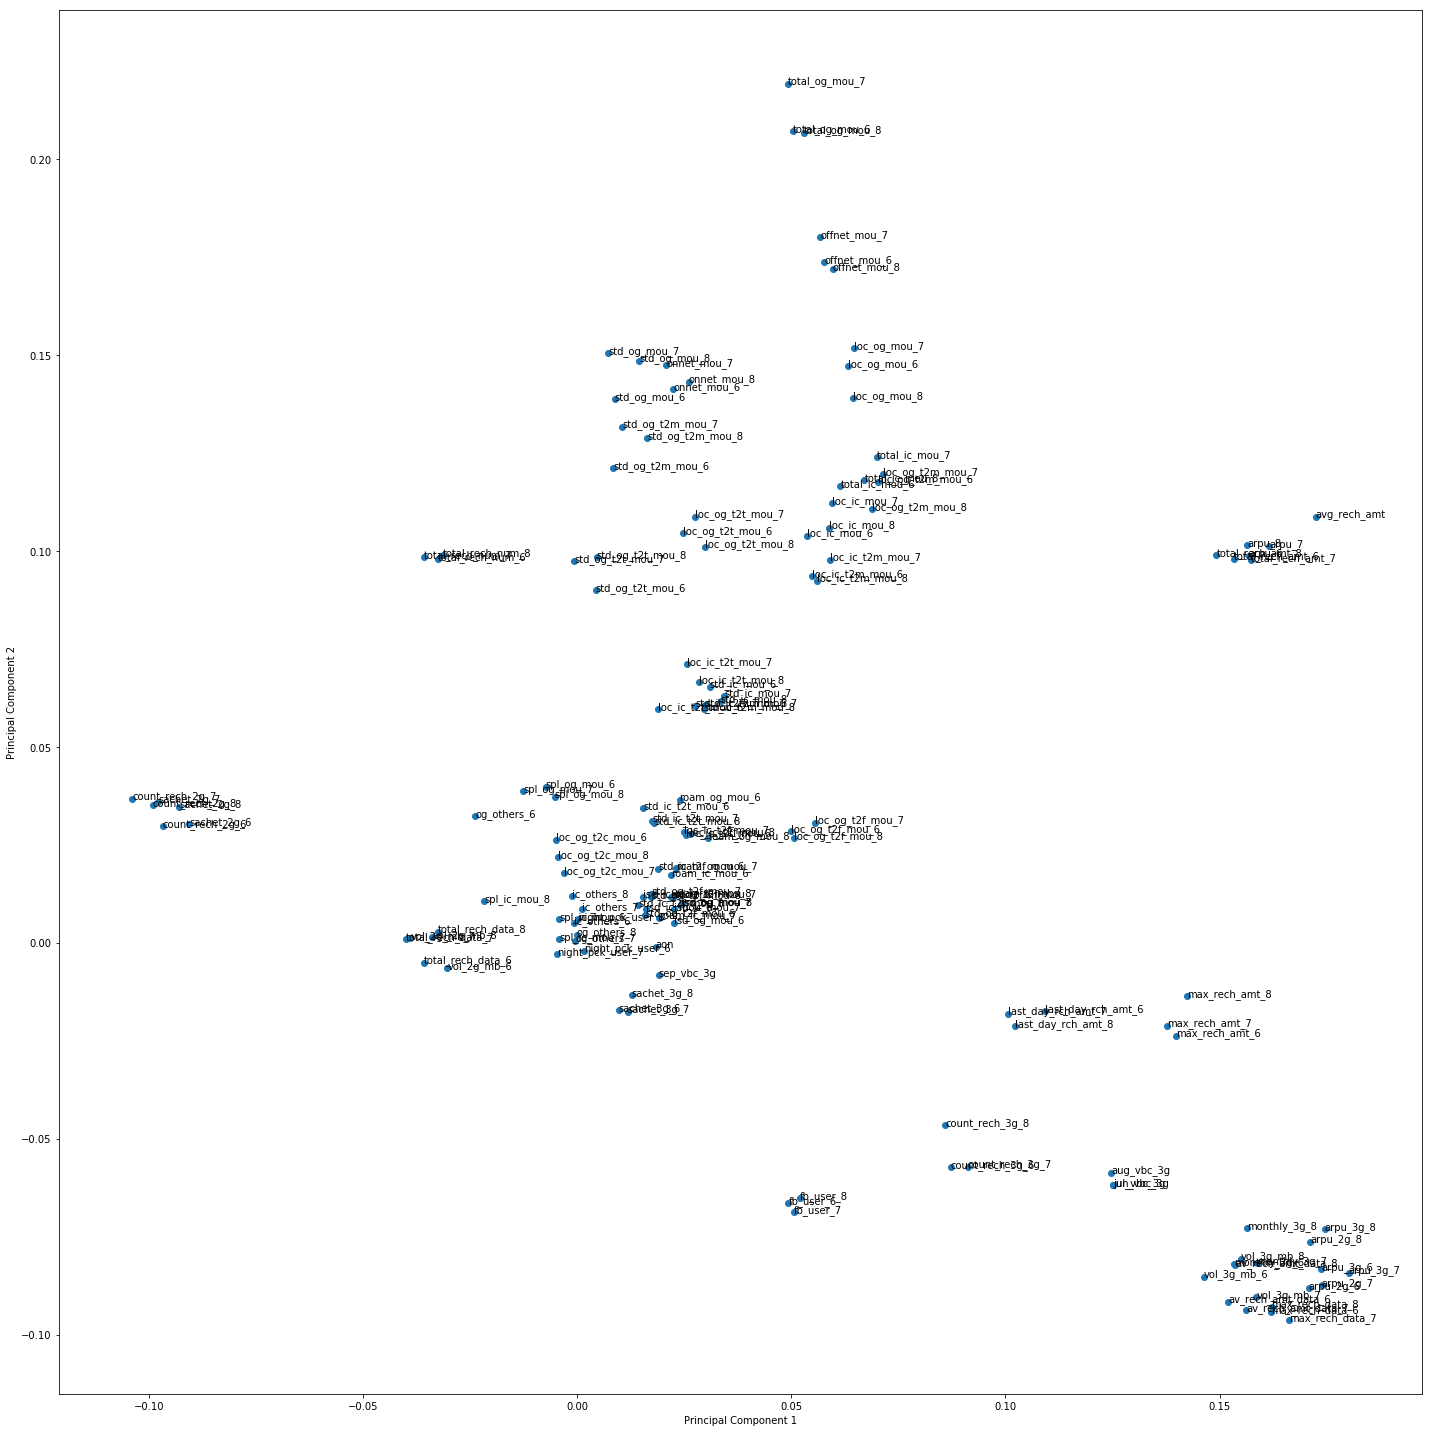

In [79]:
fig = plt.figure(figsize = (20,20))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [80]:
print(np.cumsum(pca1.explained_variance_ratio_))

[0.12062567 0.21548737 0.28972858 0.3442825  0.38535536 0.4157519
 0.44141602 0.46472032 0.48657525 0.50775796 0.52821153 0.54814676
 0.56735235 0.58589554 0.60398179 0.62019895 0.63548142 0.6498956
 0.66404393 0.67680489 0.68936817 0.70180811 0.71345415 0.7248172
 0.73482617 0.74445285 0.7532283  0.76130147 0.76927973 0.77682169
 0.78423373 0.7913993  0.79818434 0.80491136 0.81154449 0.8180142
 0.82416658 0.83012258 0.83599157 0.84158055 0.84711163 0.85248278
 0.85770049 0.86289464 0.86791376 0.87266885 0.87707663 0.88145097
 0.88573855 0.8899486  0.89394254 0.89775023 0.90147622 0.90500648
 0.908494   0.91189223 0.91520218 0.91826522 0.9212669  0.92419334
 0.92706958 0.9298839  0.93261861 0.93531881 0.93783414 0.94033279
 0.94274419 0.94509303 0.94733394 0.94947905 0.95155502 0.95357631
 0.95557978 0.95750718 0.95939188 0.96123216 0.96303229 0.96474657
 0.96642946 0.96810429 0.96966927 0.97119893 0.97271239 0.97418953
 0.97562899 0.9770358  0.9784144  0.97975355 0.98106854 0.98233165

#### Looking at the screeplot to assess the number of needed principal components

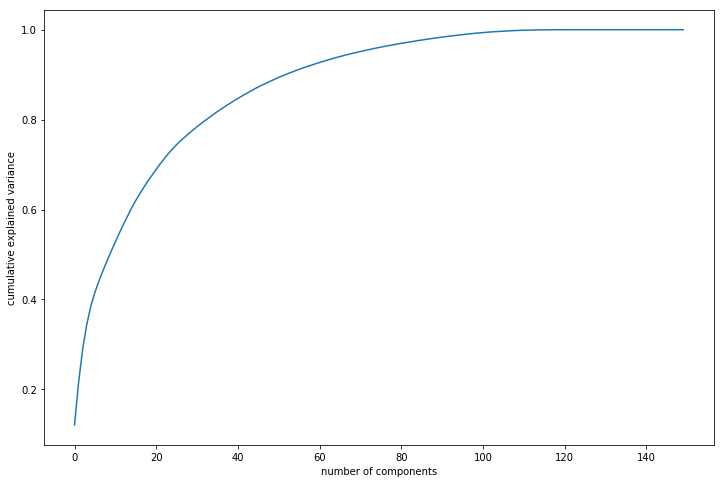

In [81]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [82]:
# Find out exactly ho many components explain 95% of variance.
pca2 = PCA(0.80)

In [83]:
df_train_pca2 = pca2.fit_transform(X_train)
df_train_pca2.shape

(5300, 34)